In [1]:
#pip install pydot

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# METRICS
from sklearn.metrics import f1_score

# TRAIN TEST SPLIT
from sklearn.model_selection import train_test_split

# SCALING
from sklearn.preprocessing import StandardScaler

# TENSORFLOW
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

2023-02-18 00:27:11.343159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Data

In [3]:
data_path='../MATERIALS/DATA/processed_data/transaction_data.csv'
df       =pd.read_csv(data_path).drop('Unnamed: 0', axis=1)

In [4]:
data=pd.to_datetime(df.DATA)
np.unique(data.dt.year) # ONLY ONE YEAR!

array([2022])

In [5]:
df['DATA']=data

# Further Time Series Data Processing

Idea is to have a DataFrame for each client where every row is the sum of all variables within a week. 

We must add ghost rows on each 1st day of the week, to make sure all DataFrames have the same size.

In [6]:
FREQUENCY='w'

In [7]:
ghost_index=pd.date_range(start='2022-01-01', end='2022-05-1', freq=FREQUENCY)

Start be creating a DataFrame for each client

In [8]:
client_dataframes=dict()
client_target    =dict()
unique_clients   = np.unique(df.ID)

for client_ID in unique_clients:
    client_dataframes[client_ID]=df[df.ID==client_ID].set_index('DATA').drop(['ID', 'target'], axis=1)
    client_target[client_ID]=np.mean(df[df.ID==client_ID].target).astype(int)

In [9]:
#TEST TO GET START AND END DAY OF COUNTING
#client=client_dataframes[171]
#client.sort_values(by='DATA').index[-1]

Finally, resample on a weekly basis

In [10]:
# TAKES TOO LONG TO RUN - POORLY OPTIMIZED CODE
for client_ID in unique_clients:
    client=client_dataframes[client_ID]
    for index in ghost_index:
        client.loc[len(client)] = 0                             # Adds ghost row on index=len(client)
        client.rename(index={len(client)-1:index},inplace=True) # Changes ghost row index to time data
    client_dataframes[client_ID]=client.resample(FREQUENCY).sum()

Check all client DataFrames have same dimentions

In [11]:
check=client_dataframes[1].shape

sum([client_dataframes[client_ID].shape!=check for client_ID in unique_clients])

0

save DataFrame as .csv

In [12]:
dataset_time=pd.DataFrame({})

for client_ID in unique_clients:
    
    client=client_dataframes[client_ID]
    client[['ID', 'target']]=[client_ID, client_target[client_ID]]
    
    frames = [dataset_time, client]
    dataset_time = pd.concat(frames)

In [13]:
dataset_time.reset_index(inplace=True)
dataset_time.index=dataset_time.ID
dataset_time.drop('ID', inplace=True, axis=1)

In [14]:
dataset_time.to_csv('../MATERIALS/DATA/processed_data/processed_time_dataset.csv')

## Train Test Split (Data not Shuffled)

In [15]:
train_size=int(len(client_dataframes)*0.8)

#IF WE WANT TO SHUFFLE

#idx = np.random.permutation(len(x_train))
#x_train = x_train[idx]
#y_train = y_train[idx]

X_train=[client_dataframes[i].drop(['ID', 'target'], axis=1) for i in list(client_dataframes.keys())[:train_size]]
y_train=[int(np.mean(client_dataframes[i].target)) for i in list(client_dataframes.keys())[:train_size]]

X_test=[client_dataframes[i].drop(['ID', 'target'], axis=1) for i in list(client_dataframes.keys())[train_size:]]
y_test=[int(np.mean(client_dataframes[i].target)) for i in list(client_dataframes.keys())[train_size:]]

# PUT ON RIGHT FORMAT
X_train=np.array([np.array(x) for x in X_train])
X_test=np.array([np.array(x) for x in X_test])

y_train=np.array(y_train)
y_test=np.array(y_test)


## STANDARDIZE (OPTIONAL)
# define standard scaler
#scaler = StandardScaler()
#scaler.fit(X)
# transform data
#
#X_train=scaler.transform(X_train)
#X_test=scaler.transform(X_test)

# Metrics for Keras

In [16]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# LSTM Classifier Model

Find explanation [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

More code [here](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/)

Imbalanced Dataset [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

In [17]:
# INITIAL BIAS to deal with data imbalance - OPTIONAL
total = len(client_target)
pos   = np.sum(list(client_target.values()))
neg   = total - pos

initial_bias = np.log([pos/neg])

output_bias = tf.keras.initializers.Constant(initial_bias)

# CLASS WEIGHTS to deal with data imbalance - OPTIONAL. CHECK IF NEEDED

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.82
Weight for class 1: 1.28


In [18]:
X_train.shape
#X_train = X_train.reshape(1248, 18, 28)

(1248, 18, 33)

In [19]:
# create LSTM model
callback = keras.callbacks.EarlyStopping(monitor='val_f1_m',
                                        min_delta=0,
                                        patience=30,
                                        restore_best_weights=True,
                                        mode='max')

# INPUT HAS TO BE input_shape(n_examples, timesteps, n_features)


# create the model
model = Sequential()

# CONVOLUTIONAL LAYER

#model.add(layers.Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
#model.add(layers.MaxPooling1D(pool_size=2))

# BIDIRECTIONAL LSTM

#model.add(layers.Bidirectional(LSTM(100, dropout=0.1, recurrent_dropout=0.1))) # dropout

model.add(LSTM(250, dropout=0.1, recurrent_dropout=0.1)) # dropout
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid', bias_initializer=output_bias)) #bias_initializer=output_bias -> in Dense

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', f1_m])

#print(model.summary())
History=model.fit(X_train, 
                  y_train, 
                  epochs=100,
                  #validation_data=(X_test, y_test),
                  validation_split=0.1,
                  callbacks=callback,
                  # The class weights go here OPTIONAL
                  #class_weight=class_weight,
                  shuffle=True)

Epoch 1/100


2023-02-18 00:29:14.582910: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


36/36 [==============================] - 6s 74ms/step - loss: 0.6614 - accuracy: 0.6135 - f1_m: 0.0952 - val_loss: 0.7978 - val_accuracy: 0.4720 - val_f1_m: 0.0000e+00
Epoch 2/100
36/36 [==============================] - 2s 49ms/step - loss: 0.6497 - accuracy: 0.6474 - f1_m: 0.0676 - val_loss: 0.7469 - val_accuracy: 0.4800 - val_f1_m: 0.0838
Epoch 3/100
36/36 [==============================] - 2s 49ms/step - loss: 0.6432 - accuracy: 0.6545 - f1_m: 0.0796 - val_loss: 0.7659 - val_accuracy: 0.4880 - val_f1_m: 0.0806
Epoch 4/100
36/36 [==============================] - 2s 49ms/step - loss: 0.6330 - accuracy: 0.6563 - f1_m: 0.0802 - val_loss: 0.7642 - val_accuracy: 0.4720 - val_f1_m: 0.1039
Epoch 5/100
36/36 [==============================] - 2s 49ms/step - loss: 0.6354 - accuracy: 0.6518 - f1_m: 0.0791 - val_loss: 0.7318 - val_accuracy: 0.4560 - val_f1_m: 0.0776
Epoch 6/100
36/36 [==============================] - 2s 51ms/step - loss: 0.6297 - accuracy: 0.6661 - f1_m: 0.1628 - val_loss: 0

36/36 [==============================] - 2s 48ms/step - loss: 0.5750 - accuracy: 0.6999 - f1_m: 0.4002 - val_loss: 0.7863 - val_accuracy: 0.5040 - val_f1_m: 0.3867
Epoch 48/100
36/36 [==============================] - 2s 50ms/step - loss: 0.5667 - accuracy: 0.7061 - f1_m: 0.4090 - val_loss: 0.8621 - val_accuracy: 0.4480 - val_f1_m: 0.1653
Epoch 49/100
36/36 [==============================] - 2s 49ms/step - loss: 0.5635 - accuracy: 0.7017 - f1_m: 0.4031 - val_loss: 0.8841 - val_accuracy: 0.4480 - val_f1_m: 0.1670
Epoch 50/100
36/36 [==============================] - 2s 50ms/step - loss: 0.5580 - accuracy: 0.7240 - f1_m: 0.4749 - val_loss: 0.8264 - val_accuracy: 0.4720 - val_f1_m: 0.3692
Epoch 51/100
36/36 [==============================] - 2s 49ms/step - loss: 0.5729 - accuracy: 0.7008 - f1_m: 0.4275 - val_loss: 0.8158 - val_accuracy: 0.4960 - val_f1_m: 0.3902
Epoch 52/100
36/36 [==============================] - 2s 48ms/step - loss: 0.5566 - accuracy: 0.7079 - f1_m: 0.4447 - val_loss: 

In [20]:
#keras.utils.plot_model(model, show_shapes=True)

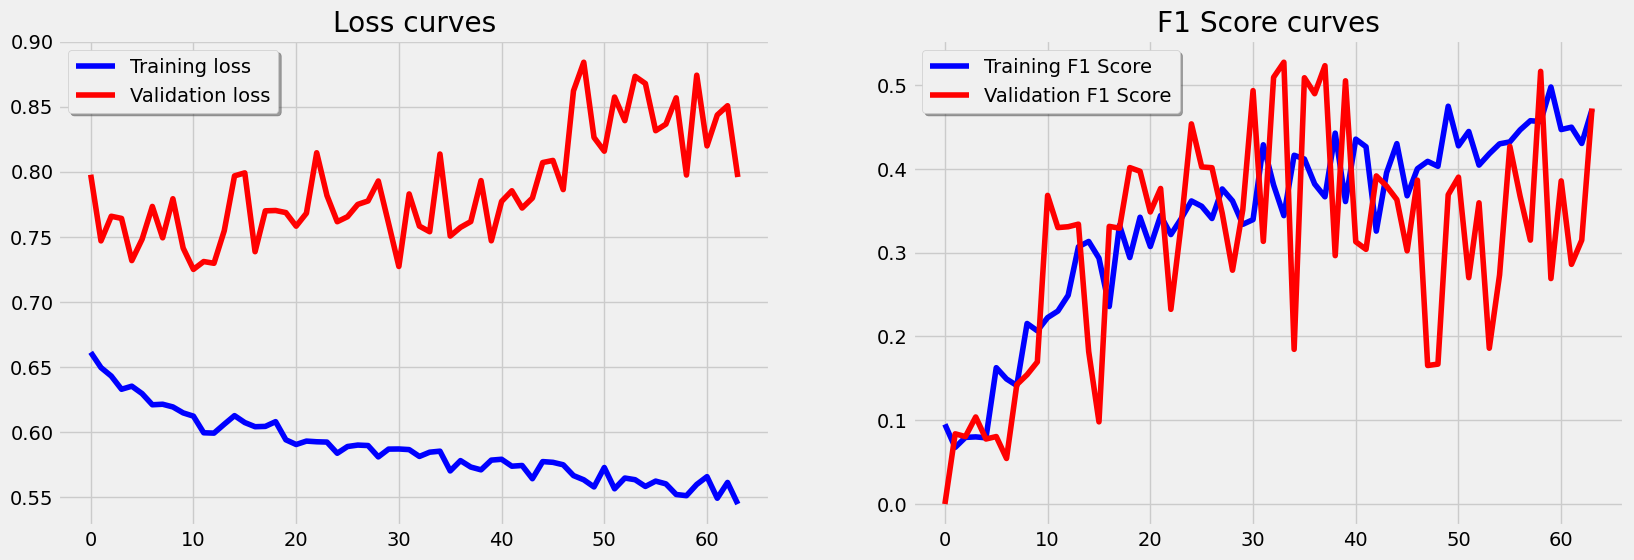

In [21]:
plt.style.use('fivethirtyeight')
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['f1_m'], color='b', label='Training F1 Score')
axs[1].plot(History.history['val_f1_m'], color='r', label='Validation F1 Score')
axs[1].set_title("F1 Score curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [22]:
lstm_pred = model.predict(X_test)

thresholds = np.linspace(0, 1, 1000)
threshold  = 0
best_f1    = 0

for k in thresholds:
    f1=f1_score([int(i>k) for i in lstm_pred], y_test)
    if f1>best_f1:
        threshold=k
        best_f1=f1

10/10 [==============================] - 0s 10ms/step


In [23]:
#lstm_pred = model.predict(X_test)
lstm_pred=[int(i>threshold) for i in lstm_pred]   # TUNE THRESHOLD!

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(lstm_pred, y_test))
print(confusion_matrix(lstm_pred, y_test))

print('\nThreshold = ', threshold)
print('\nBest F1 = ', best_f1)

              precision    recall  f1-score   support

           0       0.47      0.71      0.57       112
           1       0.77      0.56      0.65       201

    accuracy                           0.61       313
   macro avg       0.62      0.63      0.61       313
weighted avg       0.67      0.61      0.62       313

[[ 79  33]
 [ 88 113]]

Threshold =  0.42842842842842843

Best F1 =  0.6512968299711815


# CNN Classifier Model

MAYBE USE WEEKLY IN THIS CASE?

In [ ]:
X_train.shape

In [ ]:
# create LSTM model
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                        min_delta=0,
                                        patience=15,
                                        restore_best_weights=True,
                                        mode='auto')

# create the model
model = Sequential()
model.add(layers.Conv2D(32, 3, activation='softmax', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, 3, activation='softmax'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation='softmax'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='softmax'))
model.add(layers.Dense(1))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', f1_m])

print(model.summary())
History=model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1), 
                  y_train, 
                  epochs=20,
                  #validation_data=(X_test.reshape(313, 121, 28, 1), y_test),
                  validation_split=0.2,
                  callbacks=callback,
                  shuffle=True)

In [ ]:
plt.style.use('fivethirtyeight')
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
CNN_pred = model.predict(X_test)
CNN_pred=[int(round(float(i), 0)) for i in CNN_pred]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(CNN_pred, y_test))

#  Transformer Classifier Model

From keras website [here](https://keras.io/examples/timeseries/timeseries_transformer_classification/).

In [ ]:
n_classes=2

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = X_train.shape[1:]

fancy_model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model = build_model(
    input_shape,
    head_size=64,
    num_heads=2,
    ff_dim=2,
    num_transformer_blocks=2,
    mlp_units=[32],
    mlp_dropout=0.2,
    dropout=0.1,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-1),
    metrics=["accuracy", f1_m],
)
model.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_f1_m',
                                        min_delta=0,
                                        patience=25,
                                        restore_best_weights=True,
                                        mode='max')

History = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callback,
)

In [ ]:
plt.style.use('fivethirtyeight')
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
trans_pred = model.predict(X_test)
trans_pred = np.where(trans_pred[:, 0]>trans_pred[:, 1], 0, 1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(trans_pred, y_test))